Tutorial from: https://emcee.readthedocs.io/en/stable/tutorials/line/

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import emcee
import corner
from IPython.display import display, Math

Generate a true model with some model noise

In [2]:
# Choose the "true" parameters.
m_true = -0.9594
b_true = 4.294
f_true = 0.534

In [3]:
np.random.seed(123)

# Generate some synthetic data from the model.
N = 50
x = np.sort(10 * np.random.rand(N))
yerr = 0.1 + 0.5 * np.random.rand(N)
y = m_true * x + b_true
y += np.abs(f_true * y) * np.random.randn(N)
y += yerr * np.random.randn(N)

Text(0, 0.5, 'y')

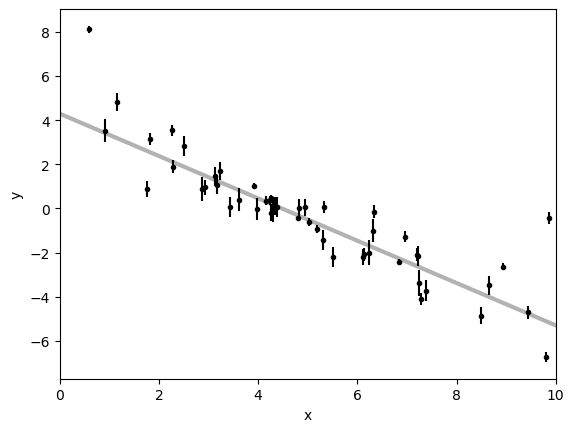

In [4]:
plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
x0 = np.linspace(0, 10, 500)
plt.plot(x0, m_true * x0 + b_true, "k", alpha=0.3, lw=3)
plt.xlim(0, 10)
plt.xlabel("x")
plt.ylabel("y")

Produce the least squares solution with the covariance matrix, as derived in: https://arxiv.org/pdf/1008.4686.pdf. Note that we don't account for the fractional error parameter $f$ in this solution.

In [5]:
# Implementation looks slightly different than the formula, but the output is the same
A = np.vander(x, 2)
C = np.diag(yerr * yerr)
ATA = np.dot(A.T, A / (yerr**2)[:, None])
cov = np.linalg.inv(ATA)
w = np.linalg.solve(ATA, np.dot(A.T, y / yerr**2))

In [6]:
print("Least-squares estimates:")
print("m = {0:.3f} ± {1:.3f}".format(w[0], np.sqrt(cov[0, 0])))
print("b = {0:.3f} ± {1:.3f}".format(w[1], np.sqrt(cov[1, 1])))

Least-squares estimates:
m = -1.104 ± 0.016
b = 5.441 ± 0.091


Text(0, 0.5, 'y')

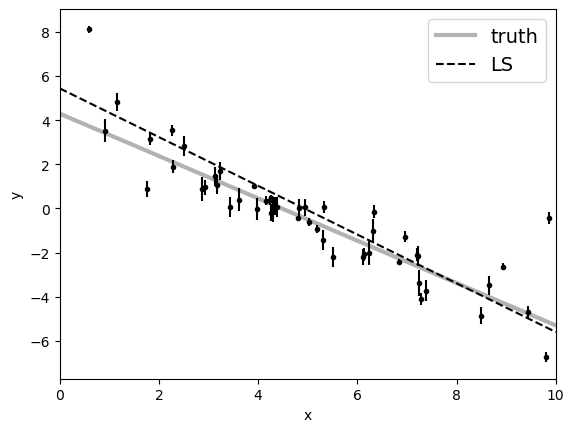

In [7]:
plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
plt.plot(x0, m_true * x0 + b_true, "k", alpha=0.3, lw=3, label="truth")
plt.plot(x0, np.dot(np.vander(x0, 2), w), "--k", label="LS")
plt.legend(fontsize=14)
plt.xlim(0, 10)
plt.xlabel("x")
plt.ylabel("y")

Now work on a maximum likelihood solution. We do account for the fractional error parameter $f$ in this solution.

In [8]:
def log_likelihood(theta, x, y, yerr):
    m, b, log_f = theta
    model = m * x + b
    # Total noise, adding Gaussian and fractional errors
    sigma2 = yerr**2 + model**2 * np.exp(2 * log_f)
    return -0.5 * np.sum((y - model) ** 2 / sigma2 + np.log(sigma2))

In [9]:
np.random.seed(42)
# Negative log likelihood
nll = lambda *args: -log_likelihood(*args)
# Simulate some error in the initial guesses
initial = np.array([m_true, b_true, np.log(f_true)]) + 0.1 * np.random.randn(3)
soln = minimize(nll, initial, args=(x, y, yerr))
m_ml, b_ml, log_f_ml = soln.x

In [10]:
print("Maximum likelihood estimates:")
print("m = {0:.3f}".format(m_ml))
print("b = {0:.3f}".format(b_ml))
print("f = {0:.3f}".format(np.exp(log_f_ml)))

Maximum likelihood estimates:
m = -1.003
b = 4.528
f = 0.454


Text(0, 0.5, 'y')

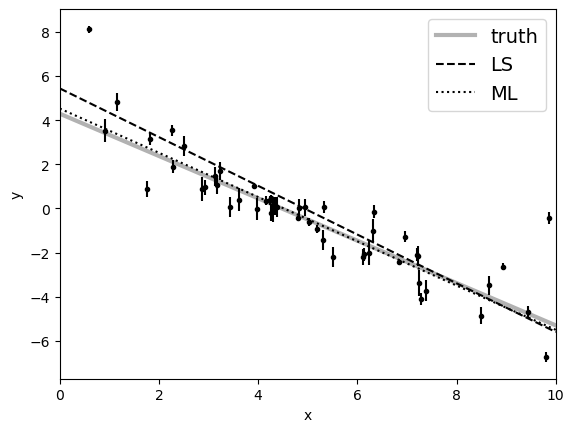

In [11]:
plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
plt.plot(x0, m_true * x0 + b_true, "k", alpha=0.3, lw=3, label="truth")
plt.plot(x0, np.dot(np.vander(x0, 2), w), "--k", label="LS")
plt.plot(x0, np.dot(np.vander(x0, 2), [m_ml, b_ml]), ":k", label="ML")
plt.legend(fontsize=14)
plt.xlim(0, 10)
plt.xlabel("x")
plt.ylabel("y")

Note that we did not get error estimates for $m$, $b$, or $f$. Also, we might not be interested in $f$ itself, but would like to see how marginalization over $f$ propagates to $m$ or $b$. This is where MCMC comes in.

In [12]:
# First, define an uninformative yet constrained prior

def log_prior(theta):
    m, b, log_f = theta
    if -5.0 < m < 0.5 and 0.0 < b < 10.0 and -10.0 < log_f < 1.0:
        return 0.0
    return -np.inf

In [13]:
def log_probability(theta, x, y, yerr):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y, yerr)

In [14]:
# Some padding applies here
pos = soln.x + 1e-4 * np.random.randn(32, 3)
nwalkers, ndim = pos.shape

In [15]:
# Now make the 32 samplers explore the posterior space
sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability, args=(x, y, yerr)
)

In [16]:
sampler.run_mcmc(pos, 5000, progress=True)

100%|█████████████████████████████████████| 5000/5000 [00:03<00:00, 1654.45it/s]


State([[-1.00017831  4.45120488 -0.42707515]
 [-1.03491477  4.76372996 -1.01735352]
 [-1.05846306  4.82734963 -0.75252072]
 [-0.96619494  4.37793385 -0.63247447]
 [-1.1342797   5.12563228 -0.830436  ]
 [-1.00349783  4.48093359 -0.7836546 ]
 [-0.99638295  4.51222943 -0.81015852]
 [-1.1429018   5.10473691 -0.54734658]
 [-1.0356259   4.77297198 -0.70504818]
 [-0.96954603  4.29291075 -0.68751348]
 [-0.9758933   4.38012774 -0.90965593]
 [-1.01031838  4.56497434 -0.81752522]
 [-1.05386367  4.6768813  -0.84114464]
 [-0.99411049  4.41975797 -0.69458326]
 [-0.94054061  4.26367715 -0.70668014]
 [-0.95217242  4.26648251 -0.77946542]
 [-1.03913489  4.64030016 -0.63905229]
 [-0.9754839   4.32777917 -0.72874076]
 [-1.05858188  4.78311205 -0.82856658]
 [-1.08380284  4.91048113 -0.94821906]
 [-1.04722825  4.64905891 -0.74254151]
 [-1.03789873  4.63312675 -0.92953131]
 [-0.95628223  4.32609736 -0.797314  ]
 [-0.91313019  4.10380921 -0.40546274]
 [-1.02565756  4.6086396  -0.89184348]
 [-0.98986953  4.46

Below we plot the chains for all walkers

Text(0.5, 0, 'step number')

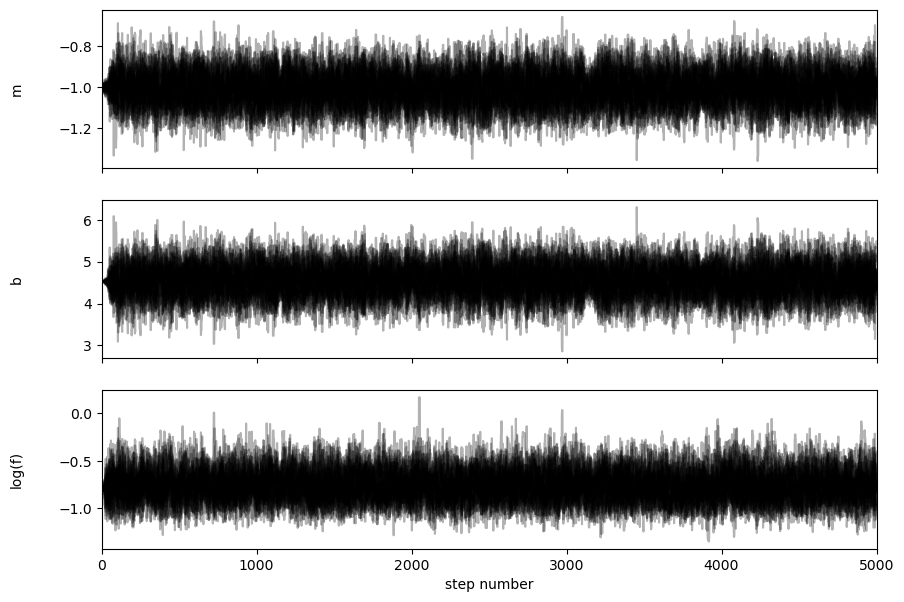

In [17]:
fig, axes = plt.subplots(3, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["m", "b", "log(f)"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number")

In [18]:
# A sense of how many steps it took for the walkers to forget their history
tau = sampler.get_autocorr_time()
print(tau)

[39.99526726 39.76501919 41.02623912]


In [19]:
# Thin is taking only every few samples from every chain
flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
print(flat_samples.shape)

(10432, 3)


Plot the posterior probability distributions

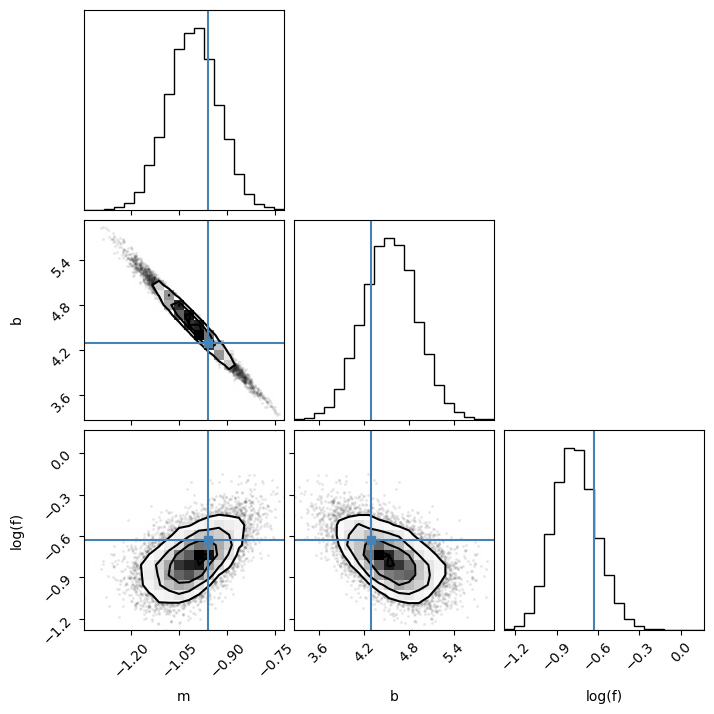

In [20]:
fig = corner.corner(
    flat_samples, labels=labels, truths=[m_true, b_true, np.log(f_true)]
)

Also plot the fit in the space of observed data

Text(0, 0.5, 'y')

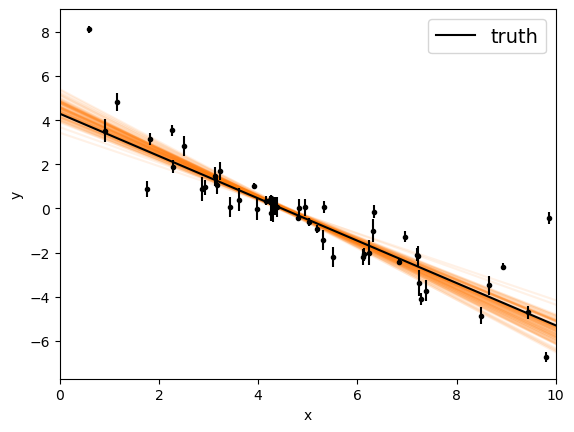

In [22]:
inds = np.random.randint(len(flat_samples), size=100)
for ind in inds:
    sample = flat_samples[ind]
    plt.plot(x0, np.dot(np.vander(x0, 2), sample[:2]), "C1", alpha=0.1)
plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
plt.plot(x0, m_true * x0 + b_true, "k", label="truth")
plt.legend(fontsize=14)
plt.xlim(0, 10)
plt.xlabel("x")
plt.ylabel("y")

In [23]:
for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>